In [1]:
import matplotlib.pyplot as plt

from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering, Birch

import pandas as pd

## Load data

In [2]:
P0_data = pd.read_csv("../data/geoplant-at-paiss/GLC25_P0_metadata_train.csv")
P0_data["data_type"] = "P0"

# Group by survey_id (place speciesId in list)
columns = P0_data.columns.tolist()
columns.remove("speciesId")
columns.remove("surveyId")

aggregations = {col: "first" for col in columns}
aggregations["speciesId"] = lambda x: x.tolist()

P0_data = P0_data.groupby("surveyId").agg(aggregations).reset_index()

P0_data = P0_data[["lat","lon","speciesId","surveyId","data_type"]]
P0_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845533 entries, 0 to 3845532
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   lat        float64
 1   lon        float64
 2   speciesId  object 
 3   surveyId   int64  
 4   data_type  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 146.7+ MB


In [3]:
PA_data = pd.read_csv("../data/geoplant-at-paiss/GLC25_PA_metadata_train.csv")
PA_data["data_type"] = "PA"

# Group by survey_id (place speciesId in list)
columns = PA_data.columns.tolist()
columns.remove("speciesId")
columns.remove("surveyId")

aggregations = {col: "first" for col in columns}
aggregations["speciesId"] = lambda x: x.tolist()

PA_data = PA_data.groupby("surveyId").agg(aggregations).reset_index()

PA_data = PA_data[["lat","lon","speciesId","surveyId","data_type"]]
PA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88987 entries, 0 to 88986
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        88987 non-null  float64
 1   lon        88987 non-null  float64
 2   speciesId  88987 non-null  object 
 3   surveyId   88987 non-null  int64  
 4   data_type  88987 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 3.4+ MB


In [4]:
Test_data = pd.read_csv("../data/geoplant-at-paiss/GLC25_PA_metadata_test.csv")
Test_data["data_type"] = "Test"

# Group by survey_id (place speciesId in list)
columns = Test_data.columns.tolist()
columns.remove("surveyId")

aggregations = {col: "first" for col in columns}

Test_data = Test_data.groupby("surveyId").agg(aggregations).reset_index()

Test_data["speciesId"] = -1
Test_data = Test_data[["lat","lon","surveyId","speciesId","data_type"]]
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14784 entries, 0 to 14783
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        14784 non-null  float64
 1   lon        14784 non-null  float64
 2   surveyId   14784 non-null  int64  
 3   speciesId  14784 non-null  int64  
 4   data_type  14784 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 577.6+ KB


In [5]:
all_data = pd.concat([P0_data, PA_data, Test_data]).reset_index(drop=True)
all_data.head()

,lat,lon,speciesId,surveyId,data_type
0,43.74605,1.573057,[3383.0],1,P0
1,42.12559,0.314948,[1152.0],2,P0
2,48.29520,-0.934518,[6772.0],3,P0
3,53.63367,-2.644535,[3318.0],4,P0
4,49.79471,7.925086,[3374.0],5,P0


In [6]:
all_data["lon"] = all_data["lon"] * (1 - all_data["lat"] / 90) # As we closer to poles, the longitude distance is smaller
all_data["lon"] = all_data["lon"] * 111700 # Convert degrees to meters
all_data["lat"] = all_data["lat"] * 111700 # Convert degrees to meters

## Make 2d clusterization

In [7]:
clustering = DBSCAN(eps=500, min_samples=3).fit(all_data[["lat","lon"]]) # eps is taken by reclustering only on PA (this is the highest value to make all surveys separated)
all_data["cluster"] = clustering.labels_
P0_data = all_data[all_data["data_type"] == "P0"].reset_index(drop=True)
PA_data = all_data[all_data["data_type"] == "PA"].reset_index(drop=True)
Test_data = all_data[all_data["data_type"] == "Test"].reset_index(drop=True)

## visualize clusters

In [8]:
print(f"Number of clusters found: {len(set(P0_data['cluster']))} of {len(P0_data)} P0 points")
print(f"Number of clusters found: {len(set(PA_data['cluster']))} of {len(PA_data)} PA points")
print(f"Number of clusters found: {len(set(Test_data['cluster']))} of {len(Test_data)} PA points")

Number of clusters found: 153472 of 3845533 P0 points
Number of clusters found: 8757 of 88987 PA points
Number of clusters found: 1674 of 14784 PA points


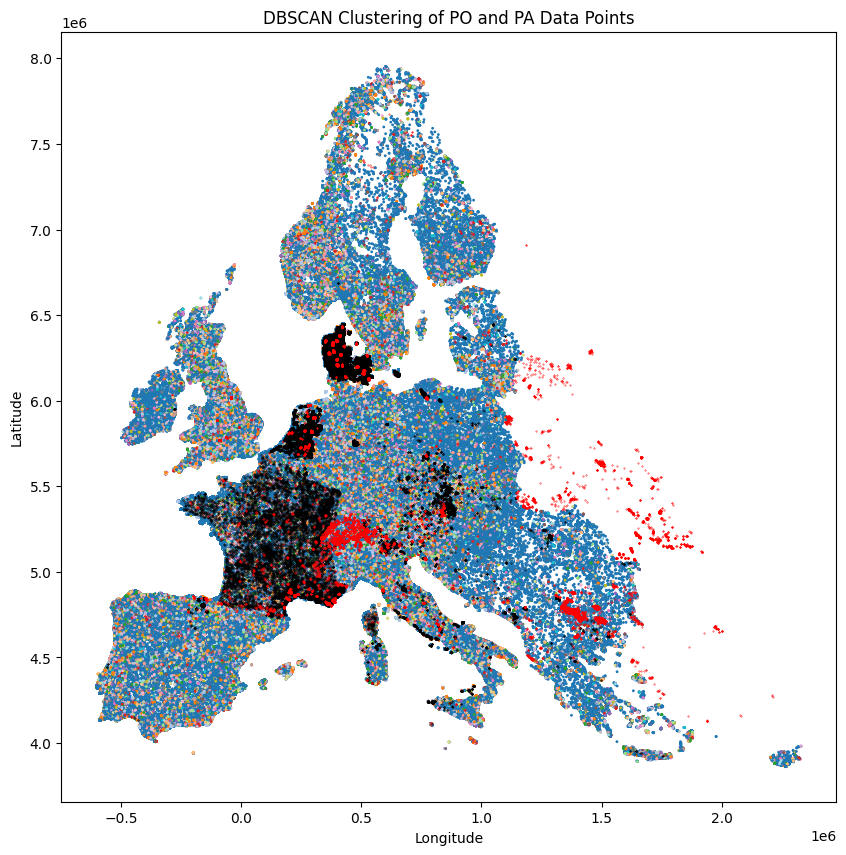

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(P0_data["lon"], P0_data["lat"], c=P0_data["cluster"], cmap="tab20", s=1)
plt.scatter(PA_data["lon"], PA_data["lat"], c="black", s=0.1)
plt.scatter(Test_data["lon"], Test_data["lat"], c="red", s=0.1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of PO and PA Data Points")
plt.show()

In [ ]:
from itertools import chain

def grid_clustering(data, cell_height=100, cell_width=100, min_samples=3):
    """
    Clusters data points into a grid of cells.
    :param cell_height: Height of each cell in meters.
    :param cell_width: Width of each cell in meters.
    :param min_samples: Minimum number of samples to form a cluster.
    :return: DataFrame with clusters assigned.
    """
    data = data.copy().reset_index(drop=True)

    data["lon"] = data["lon"] // cell_width * cell_width + cell_width / 2
    data["lat"] = data["lat"] // cell_height * cell_height + cell_height / 2

    data["cluster"] = data.groupby(["lon", "lat"]).ngroup()
    

    clusters_with_PA = data[data["data_type"] == "PA"]["cluster"].unique()
    data["close_to_PA"] = data["cluster"].isin(clusters_with_PA)
    
    cluster_counts = data.groupby("cluster")["speciesId"].apply(lambda x: len(set(chain.from_iterable(x))))
    # join cluster_counts back to data
    cluster_counts = data["cluster"].map(cluster_counts)
    

    print(f"Data size before filtering {len(data)}")
    data = data[(cluster_counts >= min_samples) | (data["close_to_PA"])]
    print(f"Data size after filtering {len(data)}")

    # Remove all clusters with data_type == PA in clusters

    PA_cluster_species = data[
        (data["data_type"] == "PA") & (data["cluster"].isin(clusters_with_PA))
    ].groupby("cluster").agg({"speciesId": lambda x: set(chain.from_iterable(x))})
    P0_cluster_species = data[
        (data["data_type"] == "P0") & (data["cluster"].isin(clusters_with_PA))
    ].groupby("cluster").agg({"speciesId": lambda x: set(chain.from_iterable(x))})

    joined_species = PA_cluster_species.merge(
        P0_cluster_species,
        on="cluster",
        suffixes=("_PA", "_P0"),
    )

     # For each cluster in clusters_with_PA, print amount of points in that cluster that are in PA but not in P0, and vice versa

    PA_minus_P0 = joined_species.apply(lambda row: len(row["speciesId_PA"] - row["speciesId_P0"]), axis=1).mean()
    P0_minus_PA = joined_species.apply(lambda row: len(row["speciesId_P0"] - row["speciesId_PA"]), axis=1).mean()
    P0_and_PA = joined_species.apply(lambda row: len(row["speciesId_P0"] & row["speciesId_PA"]), axis=1).mean()

    print(f"Mean number of PA points in clusters with PA but no P0: {PA_minus_P0}")
    print(f"Mean number of P0 points in clusters with PA but no PA: {P0_minus_PA}")
    print(f"Mean number of points both in PA and P0 in clusters with PA: {P0_and_PA}")

    data_out = data[data["data_type"] != "PA"].reset_index(drop=True)

    return data_out

In [22]:
data_grid = grid_clustering(pd.concat([P0_data, PA_data]), cell_height=100, cell_width=100, min_samples=5)

print(f"Number of clusters found: {len(set(data_grid['cluster']))} of {len(data_grid)} points")

Data size before filtering 3934520
Data size after filtering 880107
Mean number of PA points in clusters with PA but no P0: 11.496525896789693
Mean number of P0 points in clusters with PA but no PA: 1.8270014367477683
Mean number of points both in PA and P0 in clusters with PA: 6.559248180512047
Number of clusters found: 160263 of 791120 points


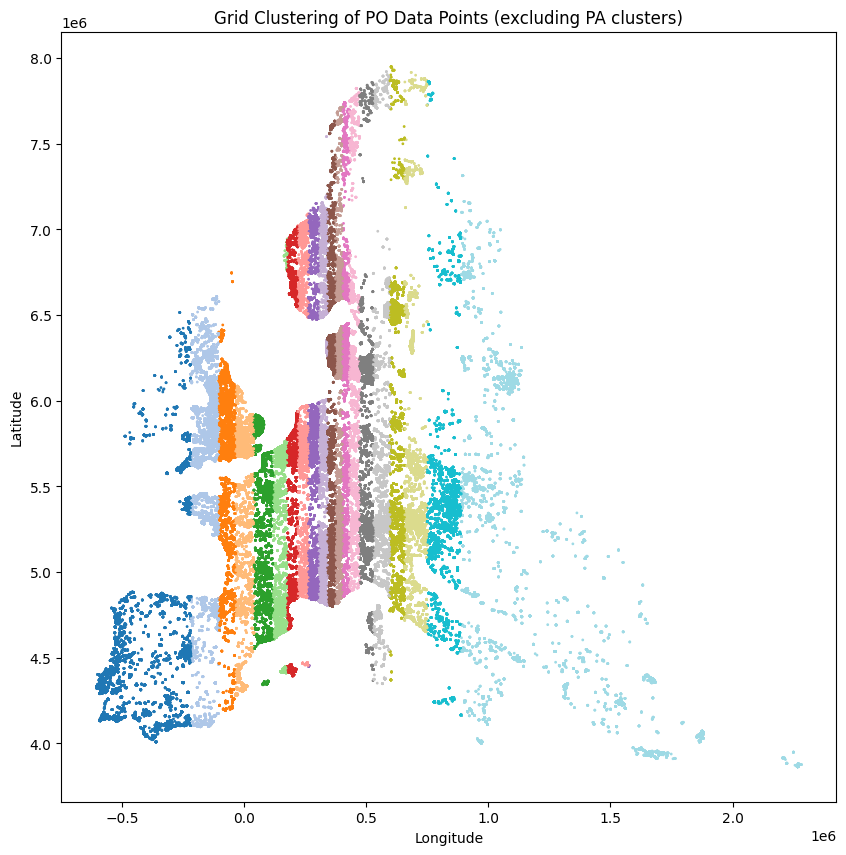

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(data_grid["lon"], data_grid["lat"], c=data_grid["cluster"], cmap="tab20", s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grid Clustering of PO Data Points (excluding PA clusters)")
plt.show()

In [24]:
data_grid

,lat,lon,speciesId,surveyId,data_type,cluster,close_to_PA
0,4115050.0,-355650.0,"[320.0, 908.0, 10748.0, 9572.0]",12,P0,58514,False
1,6220550.0,354450.0,"[10218.0, 1180.0, 398.0, 7613.0, 7333.0, 6491....",26,P0,1277623,True
2,5365450.0,365150.0,[7746.0],27,P0,1319064,False
3,5213950.0,66250.0,[2893.0],28,P0,524938,False
4,5841950.0,246950.0,[11014.0],30,P0,940495,False
...,...,...,...,...,...,...,...
791115,5297450.0,494450.0,[5093.0],3919633,P0,1773158,False
791116,5566050.0,297050.0,[6551.0],3919637,P0,1082397,False
791117,6608350.0,435350.0,[5932.0],3919638,P0,1620840,False
791118,6631950.0,417350.0,"[3161.0, 10474.0]",3919654,P0,1547054,False


In [25]:
columns = data_grid.columns.tolist()
columns.remove("speciesId")
columns.remove("surveyId")
columns.remove("data_type")
columns.remove("cluster")

aggregations = {col: "first" for col in columns}
aggregations["speciesId"] = lambda x: set(chain.from_iterable(x.tolist()))
aggregations["surveyId"] = lambda x: set(x)

data_to_save = data_grid.groupby("cluster").agg(aggregations).reset_index(drop=True)

data_to_save["lat"] = data_to_save["lat"] / 111700
data_to_save["lon"] = data_to_save["lon"] / 111700 / (1 - data_to_save["lat"] / 90)
data_to_save.to_csv("../data/geoplant-at-paiss/GLC25_PO_clustered_metadata.csv", index=False)